# Ma 17

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import constants
import sympy as sym
from sympy import sympify
import scipy.stats as stats

In [3]:
#Prints a value with its error in scientific notation up to its 2 decimal
def print_scientific(value,error):
    """
    value (float) : the value
    error (float) : the error
    
    Returns:
        (string) : formatted string with the value an error
    """
    base10_error=int(np.floor(np.log10(error)))
    base10_value=int(np.floor(np.log10(np.abs(value))))
    digits=int(base10_value-base10_error+1)
    if digits<=0:
        digits=0
    base=10**base10_value
    string=f"({value/base:.{digits}f} ± {error/base:.{digits}f})·10^{base10_value}"
    return string

In [4]:
def compute_error(expression, variables, values, errors):
    """
    expression (string) : expression you used to compute the value
    variables  (list of strings) : list of variables that are in the expression in string form
    values     (list of float)   : list of values that go in the expression
    errors     (list of float)   : list of errors for each value
    
    Returns: (result, uncertainty) : tuple with the desired value and its uncertainty
    
    !! ATTENTION: Length variables = length values = length errors
    
    An example: 
    >   expression="x**2+y"
    >   var=["x","y"]; values=[2,1]; errors=[4,2]
    >   compute_error(expression, var, values, errors)
    """
    #Make variables and expression symbolic
    expression=sym.sympify(expression)
    variables=sym.symbols(variables)
    
    #To store coefficients
    coefficients=[]
    
    for index,variable in enumerate(
        variables):
        dexpression=sym.diff(expression, variable) #Differentiates expression
        coefficient=dexpression.subs(list(zip(variables, values))) #substitution
        coefficients.append(errors[index]*np.float64(coefficient)) #multiply coefficient times error
    
    uncertainty=np.sqrt(np.sum(np.array(coefficients)**2))
    result=np.float64(expression.subs(list(zip(variables, values))))

    return result,uncertainty
    

## Computing mass of monolayer Cys

Text(0, 0.5, 'Frequency (Hz)')

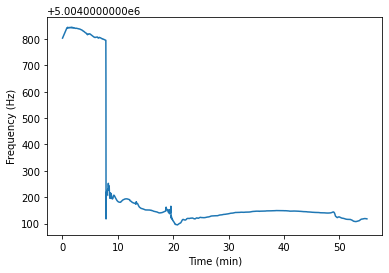

In [7]:
#Load dataframe
df=pd.read_csv(f"data/MUA-air.csv", sep=";")
frequency=np.array(df["Frequency"])
time=np.array(df["Time (s)"])
plt.plot(time/60, frequency)
plt.xlabel("Time (min)")
plt.ylabel("Frequency (Hz)")

The first part corresponds to oscillations in the air. After the 20 minute mark the cytochrome protein was added. 

### Selecting the slice

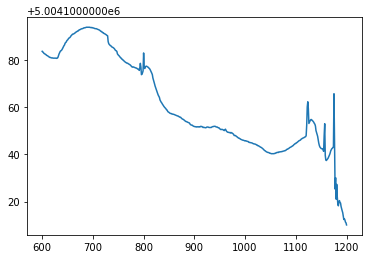

In [15]:
time_slice=[time>=10*60 and time<=20*60 for time in time]
plt.plot(time[time_slice],frequency[time_slice])

In [26]:
time_MUA=time[time_slice]; freq_MUA=frequency[time_slice]

We are going to use the baseline obtained from the last task as here we can not do a regression as adsorption may be still happening.

In [34]:
#Previous results
rho_q=2.648*(constants.gram)*(constants.centi)**(-3)
stdrho_q=0.001*(constants.gram)*(constants.centi)**(-3)
deltaf_L, stddeltaf_L=np.load("results/task1/Deltaf_experimental.npy")
d_q, stdd_q=np.load("results/task1/d_q.npy")
f_0, stdf_0=np.load("results/task1/eigenfreq_air.npy")
A=np.pi*(constants.inch/2)**2
deltaf_L=-deltaf_L
linregression_eth=np.load("results/task2/linregression_eth.npy")
linregression_ethslope,linregression_ethintercept, linregression_ethr2,linregression_ethpvalue,linregression_ethstderr, linregression_ethintercept_stderr=linregression_eth

In [35]:
deltaf_MUA=freq_MUA-(linregression_ethslope*time_MUA+linregression_ethintercept)
mass=-(rho_q*d_q*A)/(f_0)*(deltaf_L+deltaf_MUA)

In [36]:
stddeltaf_MUA=np.sqrt((time_MUA*linregression_ethstderr)**2+linregression_ethintercept_stderr**2)

In [38]:
expression="-(rho_q*d_q*A)/(f_0)*(deltaf_L+deltaf_MUA)"
variables=["rho_q","d_q","A","f_0","deltaf_L","deltaf_MUA"]
mass_MUA=[];stdmass_MUA=[]
for index,deltaf in enumerate(deltaf_MUA):
    mass, stdmass=compute_error(expression,variables,[rho_q,d_q,A,f_0,deltaf_L,deltaf],
                  [stdrho_q,stdd_q,A*0.1,stdf_0,stddeltaf_L,stddeltaf_MUA[index]])
    mass_MUA.append(mass);stdmass_MUA.append(stdmass)
mass_MUA=np.array(mass_MUA); stdmass_MUA=np.array(stdmass_MUA)

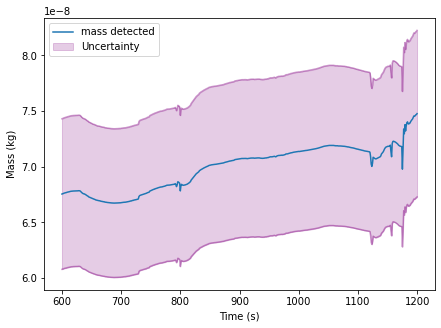

In [39]:
fig, axis=plt.subplots(1,1,figsize=(7,5))
axis.plot(time_MUA,mass_MUA, label="mass detected")
axis.plot(time_MUA,mass_MUA+stdmass_MUA, color="purple", alpha=0.4)
axis.plot(time_MUA,mass_MUA-stdmass_MUA, color="purple", alpha=0.4)
axis.fill_between(time_MUA, mass_MUA+stdmass_MUA, mass_MUA-stdmass_MUA,
                color="purple", alpha=0.2, label="Uncertainty")
axis.set_xlabel("Time (s)"); axis.set_ylabel("Mass (kg)")
axis.legend()

### Mass of the cys protein

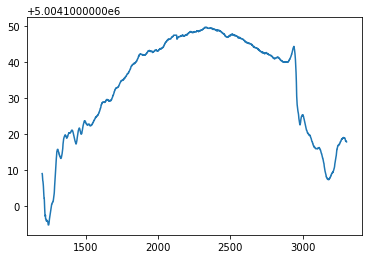

In [10]:
time_slice=time[time>=20*60]
freq_slice=frequency[time>=20*60]
plt.plot(time_slice,freq_slice)

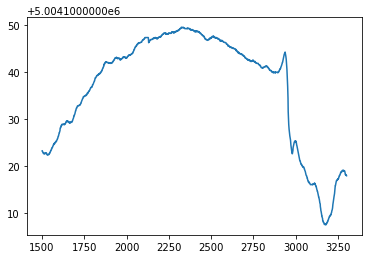

In [14]:
selection=[time>=1500 for time in time]
time_cys=time[selection]; freq_cys=frequency[selection]
plt.plot(time_cys, freq_cys)

In [68]:
deltaf_cys=freq_cys-(linregression_ethslope*time_cys+linregression_ethintercept)
mass_cys=-(rho_q*d_q*A)/(f_0)*(deltaf_L+deltaf_cys)

In [69]:
stddeltaf_cys=np.sqrt((time_cys*linregression_ethstderr)**2+linregression_ethintercept_stderr**2)

In [75]:
expression=f"-(rho_q*d_q*A)/(f_0)*(deltaf_L+deltaf_cys)"
variables=["rho_q","d_q","A","f_0","deltaf_L","deltaf_cys"]
mass_cys=[];stdmass_cys=[]
for index,deltaf in enumerate(deltaf_cys):
    mass, stdmass=compute_error(expression,variables,[rho_q,d_q,A,f_0,deltaf_L,deltaf],
                  [stdrho_q,stdd_q,A*0.1,stdf_0,stddeltaf_L,stddeltaf_cys[index]])
    mass_cys.append(mass);stdmass_cys.append(stdmass)
mass_cys=np.array(mass_cys)-np.mean(mass_MUA); stdmass_cys=np.array(stdmass_cys)

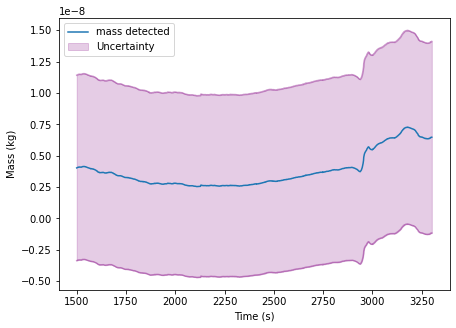

In [76]:
fig, axis=plt.subplots(1,1,figsize=(7,5))
axis.plot(time_cys,mass_cys, label="mass detected")
axis.plot(time_cys,mass_cys+stdmass_cys, color="purple", alpha=0.4)
axis.plot(time_cys,mass_cys-stdmass_cys, color="purple", alpha=0.4)
axis.fill_between(time_cys, mass_cys+stdmass_cys, mass_cys-stdmass_cys,
                color="purple", alpha=0.2, label="Uncertainty")
axis.set_xlabel("Time (s)"); axis.set_ylabel("Mass (kg)")
axis.legend()

-70.15257424331388